In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import wquantiles
from statsmodels import robust

In [2]:
try:
    data_dir = Path(".").resolve().parent.parent / "data"
    assert data_dir.is_dir()
except Exception as e:
    print(e)

## Dataset paths

In [90]:
STATE_CSV = data_dir / 'state.csv'
AIRPORT_DELAYS_CSV = data_dir / 'dfw_airline.csv'

### Locations

In [4]:
state_df = pd.read_csv(STATE_CSV)
state_df.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


In [5]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         50 non-null     object 
 1   Population    50 non-null     int64  
 2   Murder.Rate   50 non-null     float64
 3   Abbreviation  50 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB


In [6]:
state_df.Population.mean() # mean

6162876.3

In [7]:
# Trim mean(data, fraction)
# leve the fraction from ordered values from the head and the tail
def my_trim_mean(data: pd.core.series.Series, fraction: float) -> float:
    data_l = len(data)
    n = int(data_l * fraction)
    return sum(sorted(data)[n:-n])/(data_l - 2*n)

print(f"My implementation: {my_trim_mean(state_df.Population, 0.1)}")
from scipy.stats import trim_mean
print(f"scipy.stats implementation: {trim_mean(state_df.Population, 0.1)}")

My implementation: 4783697.125
scipy.stats implementation: 4783697.125


In [8]:
state_df.Population.median() # median

4436369.5

In [10]:
print(r_mean := state_df["Murder.Rate"].mean()) # regular mean
print(w_mean := np.average(state_df["Murder.Rate"], weights=state_df["Population"])) # weighted mean
print(r_median := state_df["Murder.Rate"].median())
print(w_median := wquantiles.median(state_df["Murder.Rate"], weights=state_df["Population"])) # weighted median

4.066
4.445833981123393
4.0
4.4


In [34]:
state_df.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


### Variability

In [35]:
state_df["Population"].std()

6848235.347401142

In [37]:
# IQR - 75th - 25th centiles
state_df["Population"].quantile(0.75) - state_df["Population"].quantile(0.25)

4847308.0

In [46]:
# Median absolute deviation from the median
# needs to scale additionally
(state_df["Population"] - state_df["Population"].median()).abs().median()/0.6744897501960817

3849876.1459979336

In [47]:
robust.scale.mad(state_df["Population"])

3849876.1459979336

In [48]:
state_df["Murder.Rate"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64

In [50]:
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state_df["Murder.Rate"].quantile(percentages))
df.index =[f"{p*100}%" for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


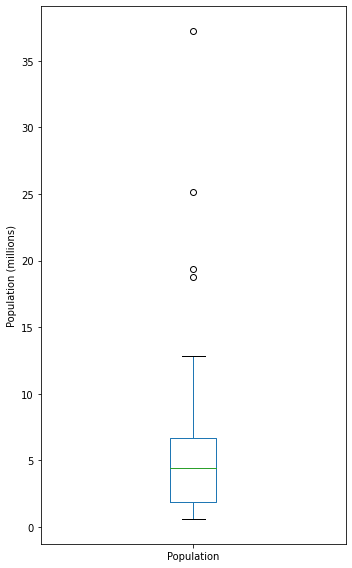

In [57]:
ax = (state_df["Population"]/10e5).plot.box(figsize=(5,8))
ax.set_ylabel("Population (millions)")

plt.tight_layout()
plt.show()


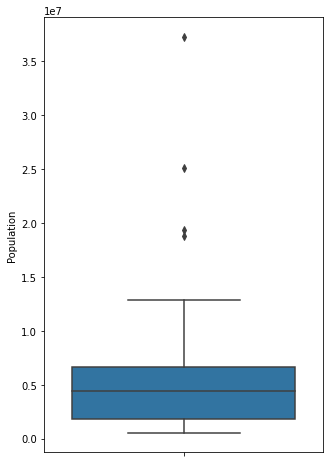

In [61]:
plt.figure(figsize=(5,8))
ax = sns.boxplot(y="Population", data=state_df)

### Frequencies and Histograms

In [65]:
binned_pop = pd.cut(state_df["Population"], 10)
binned_pop.name = "binnedPopulation"
df = pd.concat([state_df, binned_pop], axis=1)
df = df.sort_values(by="Population")

groups = []
for g, sg in df.groupby(by="binnedPopulation"):
    groups.append({
        "BinRange": g,
        "Count": len(sg),
        "States": ",".join(sg.Abbreviation)
    })
print(pd.DataFrame(groups))
print(groups)

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

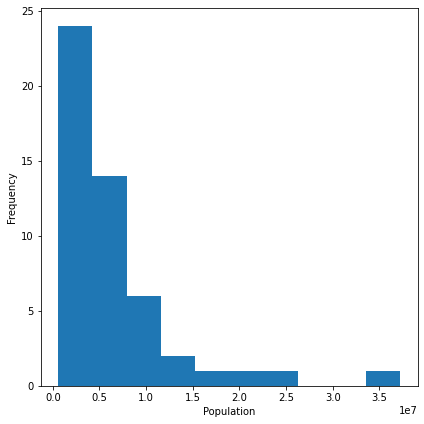

In [67]:
ax = state_df["Population"].plot.hist(figsize=(6,6))
ax.set_xlabel("Population")

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Population', ylabel='Count'>

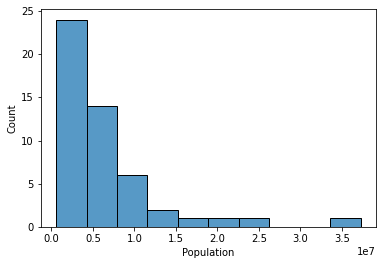

In [69]:
sns.histplot(data=state_df, x="Population", bins=10)

### Density estimates

<AxesSubplot:ylabel='Density'>

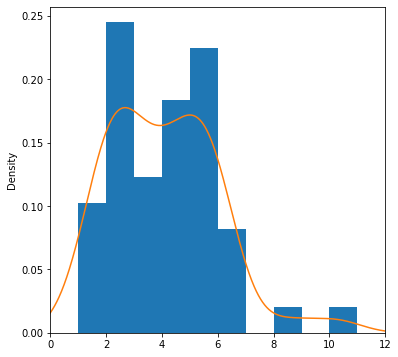

In [72]:
ax = state_df["Murder.Rate"].plot.hist(density=True, xlim=[0, 12], bins=range(1,12), figsize=(6,6))
state_df["Murder.Rate"].plot.density(ax=ax)

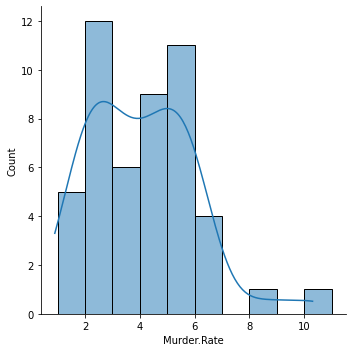

In [88]:
sns.displot(ax=ax, data=state_df, x="Murder.Rate", kde=True, bins=range(1,12))

### Binary and Categorical data

In [91]:
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
dfw.head()

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


<AxesSubplot:>

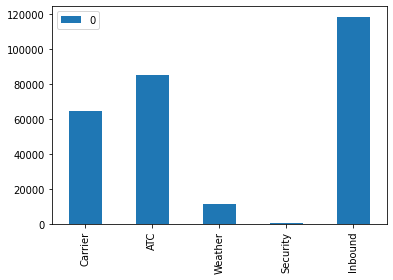

In [94]:
dfw.transpose().plot.bar()